# Denial of Service (DoS) Attack Simulation and Detection Project

#### Made by Ilchuk Oleksandr and Prytulenko Oleh, group USRS78 from NTUU

## Introduction
This project simulates and detects Denial of Service (DoS) attacks. The detected attacks are logged into a local CSV database. This notebook analyzes the logged data to answer several questions about the attacks and visualize the results.

# Part 1: Simulating and Detecting DoS Attacks

In this section, we simulate DoS attacks using randomly generated source IP addresses and a specified target IP address. The attack duration is also specified as an argument.

## Sniffing initiation
To start working we need to initialize SniffnDetect.

![sniffn_initialized](./sniffn_initialized.jpeg)

## Attacking
Here you can see an example of attack on defined ip using code from attack_simulation.py file.

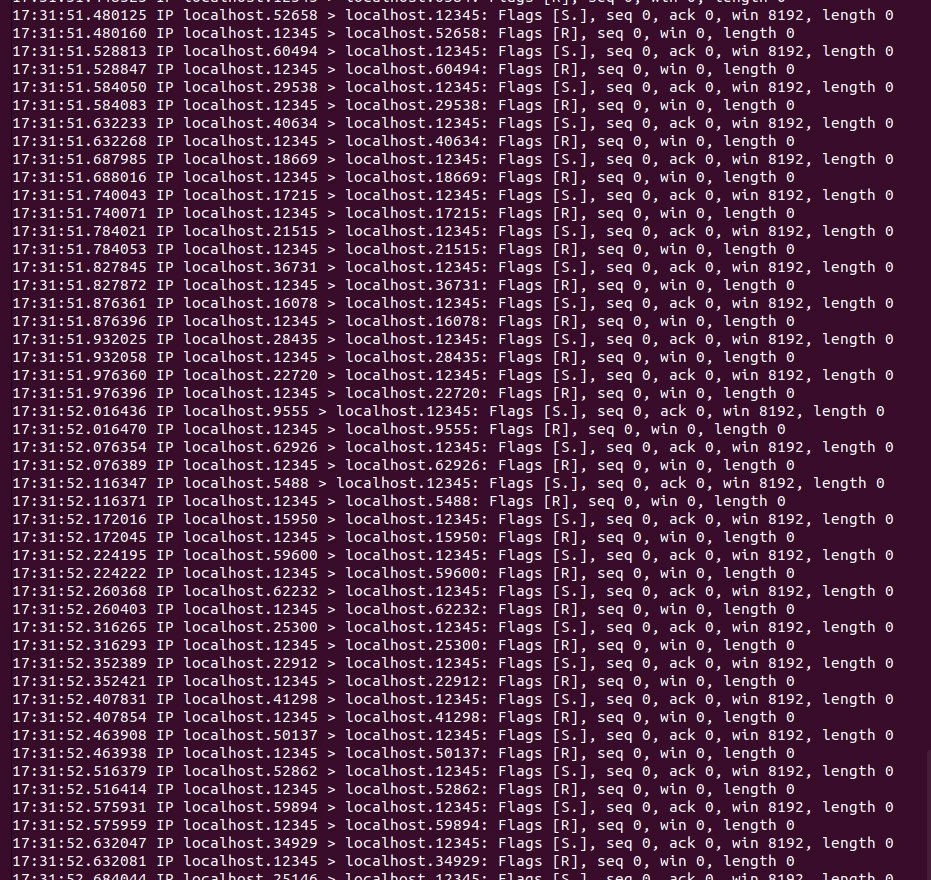

## Sniffing example
After attacking we can see that sniffing detected attacks:

![Sniffing_attack](./Sniffing_dos.jpeg)

# Part 2. Analyze detected DoS Attacks

## Load the Data
Firstly, we need to load the logged attack data from the CSV file.


In [47]:
import pandas as pd


# Define the file path of the CSV file
file_path = 'dos_attacks_log.csv'

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path, parse_dates=['timestamp'])

# Display the first few rows of the DataFrame for example
print(data[['timestamp', 'src_ip', 'dst_ip', 'attack_type', 'packet_size']].head())

            timestamp           src_ip   dst_ip attack_type  packet_size
0 2024-10-12 16:31:21    50.208.94.250  1.1.1.1         pod         1514
1 2024-10-12 16:31:21     44.210.222.9  1.1.1.1         pod         1514
2 2024-10-12 16:31:23  135.241.151.246  1.1.1.1         pod         1514
3 2024-10-12 16:31:23   143.35.119.201  1.1.1.1         pod         1514
4 2024-10-12 16:31:22    93.214.184.15  1.1.1.1         pod         1514


As we can see, data was loaded successfully.

## Analyzing the Location of Attacking Servers via IP Address

To obtain the geographical details, we can use the ip-api.com service through a web request. <br>
Below is an implementation of a function that retrieves the server’s location based on its IP address.

In [48]:
import httpx
from typing import Tuple, Optional


# Async function to get IP location from ip-api.com (CSV format)
async def get_ip_location(ip: str) -> Tuple[Optional[str], Optional[float], Optional[float]]:
    url = f"http://ip-api.com/csv/{ip}"
    
    try:
        async with httpx.AsyncClient() as client:
            response = await client.get(url, timeout=10.0)
            response.raise_for_status()
            
            responseData = response.text.split(',')
            
            if responseData[0] == 'success':
                country: str = responseData[1]       # Country is the second field in the CSV response
                lat: float = float(responseData[7])  # Latitude is the 8th field
                lon: float = float(responseData[8])  # Longitude is the 9th field
                return country, lat, lon
            else:
                return "Unknown", None, None
    except httpx.RequestError as e:
        return str(e), None, None

**_NOTE:_**
Testing IP address location detection on the full dataset could significantly increase execution time, so it was decided to conduct the test on a reduced set of data containing only 10 attack records (selected from the full file) to reduce processing time. This also simplifies the interpretation of results and the demonstration of the process.

In [49]:
import asyncio
import nest_asyncio


# Apply the nest_asyncio to allow nested event loops
nest_asyncio.apply()

# Async function to fetch all locations
async def fetch_locations(data: pd.DataFrame) -> dict:
    tasks = [get_ip_location(row['src_ip']) for _, row in data.dropna(subset=['src_ip']).iterrows()]
    results = await asyncio.gather(*tasks)
    return {row['src_ip']: result for result, (_, row) in zip(results, data.dropna(subset=['src_ip']).iterrows())}

# To run the async function in Jupyter
locations = asyncio.run(fetch_locations(data.head(10)))

# Display the locations of suspect IPs
list(map(lambda item: print(f"Ip:{item[0]} \t Location:{item[1]}"), locations.items()))

Ip:50.208.94.250 	 Location:('United States', 29.7173, -95.6296)
Ip:44.210.222.9 	 Location:('United States', 39.0438, -77.4874)
Ip:135.241.151.246 	 Location:('United Kingdom', 51.5072, -0.127586)
Ip:143.35.119.201 	 Location:('Germany', 50.1109, 8.68213)
Ip:93.214.184.15 	 Location:('Germany', 53.9661, 14.1455)
Ip:3.145.29.234 	 Location:('United States', 40.0992, -83.1141)
Ip:114.141.212.174 	 Location:('Singapore', 1.35214, 103.861)
Ip:50.163.67.38 	 Location:('United States', 39.7523, -104.984)
Ip:41.85.103.164 	 Location:('South Africa', -33.9432, 18.4709)
Ip:208.61.142.3 	 Location:('United States', 33.5186, -86.8104)


[None, None, None, None, None, None, None, None, None, None]

We can use cartopy package to plot suspects using their lattitude and longtitude:
<br><br>
**_NOTE:_** Some of ips are private and we cannot access them, but we can see most of suspects on map.

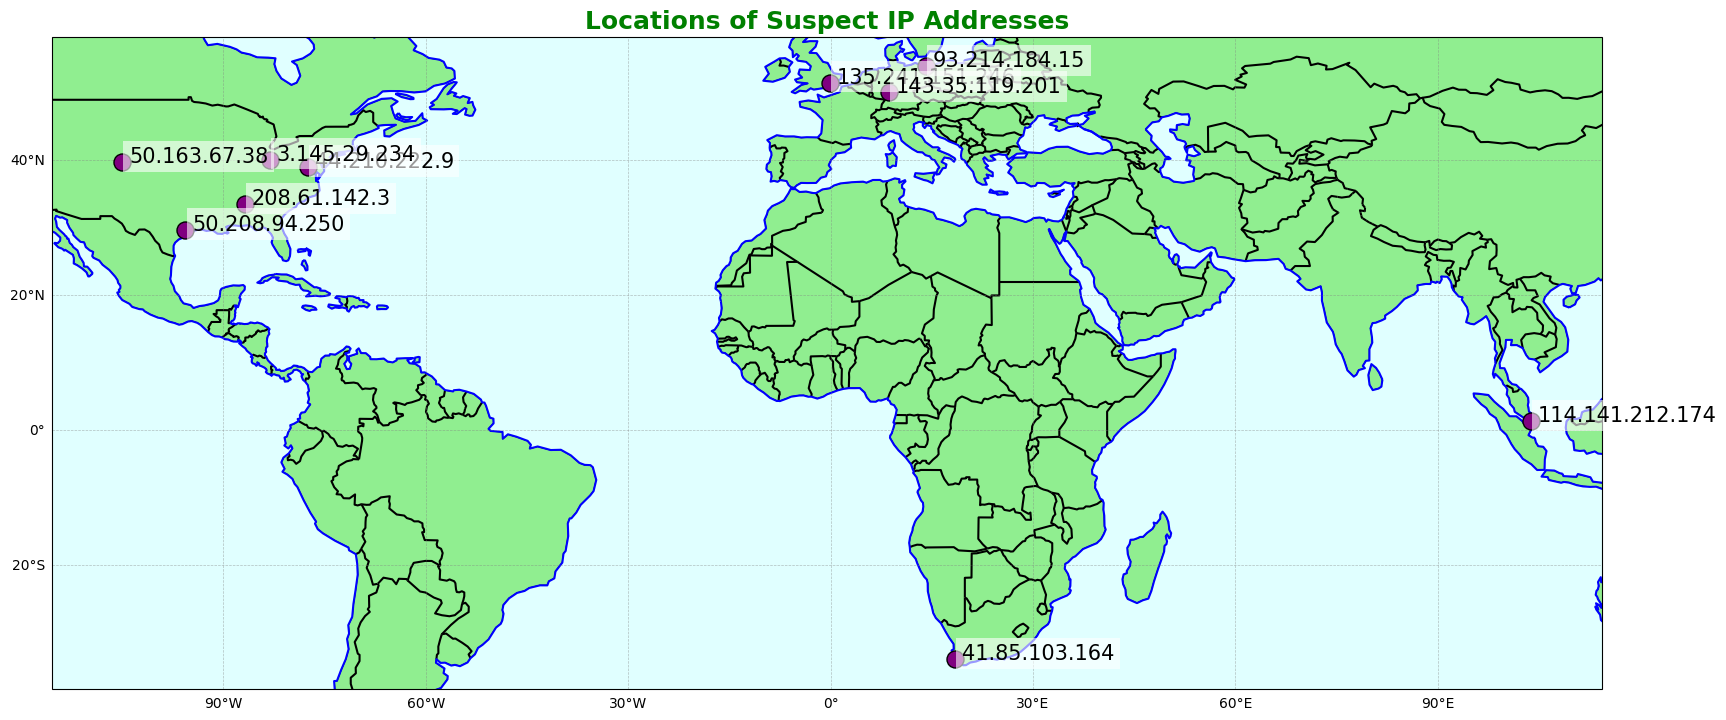

In [50]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def filter_location_data(locations):
    """Filter location data to include only those with valid coordinates."""
    return [(ip, loc[1], loc[2]) for ip, loc in locations.items() if loc[1] is not None and loc[2] is not None]


def plot_ip_locations(locations, title='Locations of Suspect IP Addresses', 
                      figsize=(15, 10), land_color='lightgreen', ocean_color='lightblue', 
                      borders_color='darkblue', coastline_color='gray', point_color='red', 
                      point_size=120, annotate_color='darkred', title_color='darkblue'):
    """Plot suspect IP addresses on a map using Cartopy with customizable visual features."""
    
    # Filter the location data
    location_data = filter_location_data(locations)
    
    if not location_data:
        print("No data available for plotting.")
        return
    
    # Extract data for plotting
    ips, latitudes, longitudes = zip(*location_data)
    
    # Set up figure size and projection
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add map features with customizable colors
    ax.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor=borders_color)  # Customizable borders
    ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor=coastline_color)  # Customizable coastlines
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor=land_color)  # Customizable land color
    ax.add_feature(cfeature.OCEAN, facecolor=ocean_color)  # Customizable ocean color
    
    # Add gridlines for better geographic reference
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Scatter suspect IP locations on the map with customizable point color and size
    ax.scatter(longitudes, latitudes, color=point_color, marker='o', s=point_size, 
               transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')
    
    # Annotate IP addresses on the map with customizable annotation color
    for ip, lon, lat in zip(ips, longitudes, latitudes):
        ax.text(lon + 1, lat, ip, fontsize=15, transform=ccrs.PlateCarree(), 
                zorder=10, color=annotate_color, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
    # Set title with customizable font properties
    ax.set_title(title, fontsize=18, fontweight='bold', color=title_color)
    
    # Show the plot
    plt.show()


plot_ip_locations(
    locations, 
    title='Locations of Suspect IP Addresses', 
    figsize=(20, 12), 
    land_color='lightgreen', 
    ocean_color='lightcyan', 
    borders_color='black', 
    coastline_color='blue', 
    point_color='purple', 
    point_size=150, 
    annotate_color='black', 
    title_color='green'
)

## DoS Attack Metrics

#### Analize which type of attack generated most packages

In [51]:
print(f"The attack type with the highest number of packets: {data['attack_type'].mode()[0]}")

The attack type with the highest number of packets: syn_flood


#### Analize which type of attack was with the largest traffic in byte

In [52]:
# 3. What is the attack that generated the largest traffic in terms of bytes?
# Calculate total traffic per attack type
data['total_bytes'] = data['packet_size'] * data['packet_size'].count()  # Assuming each entry has the same packet size
traffic_per_attack = data.groupby('attack_type')['total_bytes'].sum()

largest_traffic_attack = traffic_per_attack.idxmax()
largest_traffic_value = traffic_per_attack.max()

print("Attack type with the largest traffic in bytes:", largest_traffic_attack, "with", largest_traffic_value, "bytes.")

Attack type with the largest traffic in bytes: pod with 300704624 bytes.


#### Analize which type of attack was with the largest traffic in bytes per second

In [53]:
# Calculate traffic in bytes per second
packets_per_second = data['packet_size'].count()  # Total packets
time_seconds = (data['timestamp'].max() - data['timestamp'].min()).total_seconds() or 1  # Avoid division by zero

# Total bytes per second
bytes_per_second = traffic_per_attack / time_seconds
largest_bytes_per_second_attack = bytes_per_second.idxmax()
largest_bytes_per_second_value = bytes_per_second.max()
print("Attack type with the largest traffic in bytes per second:", largest_bytes_per_second_attack, "with", largest_bytes_per_second_value, "bytes/sec.")

Attack type with the largest traffic in bytes per second: pod with 323686.3552206674 bytes/sec.


#### Summarize

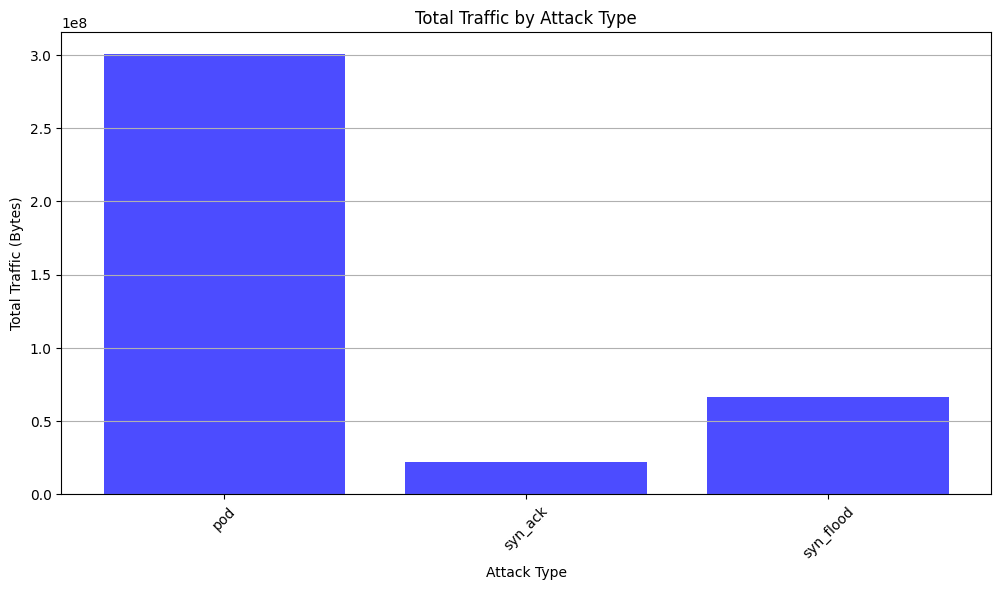

In [54]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.bar(traffic_per_attack.index, traffic_per_attack.values, color='blue', alpha=0.7)
plt.title('Total Traffic by Attack Type')
plt.xlabel('Attack Type')
plt.ylabel('Total Traffic (Bytes)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Conclusion
In this project, we developed a Python-based system to detect and analyze DoS (Denial-of-Service) attacks by logging the attack data in a CSV file and performing further analysis and visualization. The code begins by reading a CSV file (dos_attacks_log.csv) containing attack details, such as timestamps, source IP addresses, destination IP addresses, attack types, and packet sizes. The data is loaded into a Pandas DataFrame for analysis.<br><br>

#### Data Logging and Parsing
The code begins by loading a CSV file (dos_attacks_log.csv) into a Pandas DataFrame. This file contains essential details about each attack, such as timestamps, source and destination IP addresses, attack types, and packet sizes. This structured format allows for efficient data analysis and processing.<br><br>

#### IP Geolocation and Mapping
To track the origins of suspect IP addresses, the system utilizes the ip-api.com service to retrieve geographical data, including country, latitude, and longitude, based on the source IPs. This data is then plotted on a world map using Cartopy, providing a visual overview of where the attacks originated.<br><br>

#### Attack Analysis
The analysis of the attack data involved answering key questions:
1. Which attack generated the most packets? We used Pandas to count the occurrences of each attack type, identifying the attack that generated the most packets. This is crucial for assessing the intensity of each attack.
2. Which attack generated the largest traffic in bytes? By calculating the total traffic per attack type (based on packet size), we identified the attack responsible for the largest data volume. Additionally, we computed the attack that caused the highest traffic in bytes per second, revealing the most bandwidth-intensive attack.<br><br>

#### Visualization:
Using matplotlib, we created a world map that displayed the geographical locations of suspect IP addresses, giving a clear visual indication of the attackers' origins. Bar charts were also used to visualize the total traffic generated by each attack type, helping highlight the most impactful attacks in terms of bandwidth usage.